# <center>Subject activity prediction from eeg data</center>

## Import required packages

### General packages.

In [ ]:
import json
import pandas as pd
import numpy as np
import re
from time import time
import json
from scipy import stats
from scipy.interpolate import interp1d
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

### Machine Learning packages

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix ,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

### Deep Learning packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow import keras
from keras.models import Model
import keras_tuner as kt

### Hyperparameters tuning packages

In [ ]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

## Read and prepare the required datasets.

In [ ]:
#read eeg data.
df = pd.read_csv("eeg-data.csv")
#read subject metadata.
df_2 = pd.read_csv("subject-metadata.csv")
#drop uncessary columns.

In [ ]:
#join the two data frames based on id column
df_outer = pd.merge(df, df_2, left_on='id', right_on='ID', how='outer') #here id is common column
#main dataset.
df_outer

,Unnamed: 0,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label,ID,Session,Seen video before?,Chosen color,Saw icons?,Gender,Wear contacts
0,3730,12,2015-05-09 23:13:42.281,1461,2015-05-09 16:13:40.954,0,0,"[944412.0, 111373.0, 52404.0, 28390.0, 3237.0,...","[-203.0, -202.0, -196.0, -185.0, -163.0, -137....",200,2015-05-09 23:13:39.550,2015-05-09 23:13:39.549+00,unlabeled,12,1,n,g,n,m,n
1,3732,12,2015-05-09 23:13:43.186,1461,2015-05-09 16:13:41.964,0,0,"[1793049.0, 89551.0, 3896.0, 21727.0, 9301.0, ...","[104.0, 134.0, 128.0, 121.0, 145.0, 151.0, 123...",200,2015-05-09 23:13:40.559,2015-05-09 23:13:40.559+00,unlabeled,12,1,n,g,n,m,n
2,3734,12,2015-05-09 23:13:44.392,1461,2015-05-09 16:13:42.950,0,0,"[400192.0, 640624.0, 153087.0, 69733.0, 98854....","[2002.0, 2047.0, 2047.0, 2047.0, 2047.0, 2047....",200,2015-05-09 23:13:41.549,2015-05-09 23:13:41.549+00,unlabeled,12,1,n,g,n,m,n
3,3735,12,2015-05-09 23:13:45.297,1461,2015-05-09 16:13:43.935,0,0,"[681192.0, 138630.0, 67891.0, 26459.0, 592240....","[1287.0, 1241.0, 1196.0, 1155.0, 1113.0, 1072....",200,2015-05-09 23:13:42.532,2015-05-09 23:13:42.532+00,unlabeled,12,1,n,g,n,m,n
4,3737,12,2015-05-09 23:13:46.201,1460,2015-05-09 16:13:44.936,0,0,"[268406.0, 197772.0, 190654.0, 266433.0, 91683...","[1905.0, 1836.0, 1770.0, 1707.0, 1645.0, 1587....",200,2015-05-09 23:13:43.532,2015-05-09 23:13:43.532+00,unlabeled,12,1,n,g,n,m,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30008,14646,21,2015-05-09 23:49:53.089,-35,2015-05-09 16:49:53.392,0,0,"[602911.0, 35536.0, 2999.0, 701.0, 1084.0, 100...","[68.0, 33.0, 20.0, 42.0, 67.0, 73.0, 54.0, 49....",200,2015-05-09 23:49:53.497,2015-05-09 23:49:53.497+00,unlabeled,21,2,y,b,n,m,n
30009,14645,21,2015-05-09 23:49:54.295,-35,2015-05-09 16:49:54.376,0,0,"[240035.0, 263319.0, 45673.0, 18828.0, 19444.0...","[217.0, 155.0, 53.0, -40.0, -92.0, -93.0, -56....",200,2015-05-09 23:49:54.474,2015-05-09 23:49:54.474+00,unlabeled,21,2,y,b,n,m,n
30010,14647,21,2015-05-09 23:49:55.202,-33,2015-05-09 16:49:55.361,0,0,"[1720214.0, 699084.0, 846718.0, 216725.0, 2527...","[-1668.0, -1606.0, -1545.0, -1486.0, -1430.0, ...",200,2015-05-09 23:49:55.458,2015-05-09 23:49:55.458+00,unlabeled,21,2,y,b,n,m,n
30011,14648,21,2015-05-09 23:49:56.112,-33,2015-05-09 16:49:56.359,0,0,"[1352406.0, 819938.0, 931827.0, 219559.0, 2114...","[-1639.0, -1399.0, -1186.0, -742.0, -189.0, 15...",200,2015-05-09 23:49:56.454,2015-05-09 23:49:56.454+00,unlabeled,21,2,y,b,n,m,n


## Show some statistics information.

In [ ]:
print(df_outer.info())
df_outer.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30013 entries, 0 to 30012
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          30013 non-null  int64 
 1   id                  30013 non-null  int64 
 2   indra_time          30013 non-null  object
 3   browser_latency     30013 non-null  object
 4   reading_time        30013 non-null  object
 5   attention_esense    30013 non-null  int64 
 6   meditation_esense   30013 non-null  int64 
 7   eeg_power           30013 non-null  object
 8   raw_values          30013 non-null  object
 9   signal_quality      30013 non-null  int64 
 10  createdAt           30013 non-null  object
 11  updatedAt           30013 non-null  object
 12  label               30013 non-null  object
 13  ID                  30013 non-null  int64 
 14  Session             30013 non-null  int64 
 15  Seen video before?  30013 non-null  object
 16  Chosen color        30

,Unnamed: 0,id,attention_esense,meditation_esense,signal_quality,ID,Session
count,30013.000000,30013.000000,30013.000000,30013.000000,30013.000000,30013.000000,30013.000000
mean,15010.952521,13.685570,40.284710,46.638723,25.871856,13.685570,1.378736
std,8666.911131,8.479506,24.446432,26.153089,64.636640,8.479506,0.485080
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,7506.000000,6.000000,24.000000,34.000000,0.000000,6.000000,1.000000
50%,15010.000000,13.000000,43.000000,50.000000,0.000000,13.000000,1.000000
75%,22517.000000,20.000000,57.000000,64.000000,0.000000,20.000000,2.000000
max,30021.000000,30.000000,100.000000,100.000000,200.000000,30.000000,2.000000


### drop unnecessary labels (samples) and convert to binary classification.

In [ ]:
df_outer = df_outer.loc[(df_outer['label'].str.contains('math[0-9]*', regex=True)) & (df_outer['label'] != 'mathInstruction') | (df_outer['label'] == 'relax')]
df_outer.label

1157      relax
1158      relax
1159      relax
1160      relax
1161      relax
          ...  
29705    math11
29706    math11
29707    math11
29708    math12
29709    math12
Name: label, Length: 1870, dtype: object

In [ ]:
#convert every label that has math to math only
df_outer.loc[df_outer['label'].str.contains('math[0-9]*'), 'label'] = 'math'

In [ ]:
#check the shape of the data
df_outer.shape

(1870, 20)

### check if there are any duplicated values.

In [ ]:
if df_outer.duplicated().any()== True:
    print("There are duplicated values in this dataset")
else:
    print("There aren't duplicated values in this dataset")
#print the number of duplicated values.
print(f"There are {df_outer.duplicated().sum()} consistent duplicated values in this dataset.")

There aren't duplicated values in this dataset
There are 0 consistent duplicated values in this dataset.


### Check null values.

In [ ]:
if df.isna().values.any() == True:
    #this condidtion will be evaluated.
    print("There are missing values in this dataframe")
else:
    print("There aren't missing values in this dataframe")
total_miss = df.isnull().sum()
percent_miss = (total_miss/df.isnull().count()*100)

# sort attributes by missing value ratio
missing_data = pd.DataFrame({'Total missing':total_miss,'% missing':percent_miss})
missing_data.sort_values(by='Total missing',ascending=False)

There aren't missing values in this dataframe


,Total missing,% missing
Unnamed: 0,0,0.0
id,0,0.0
indra_time,0,0.0
browser_latency,0,0.0
reading_time,0,0.0
attention_esense,0,0.0
meditation_esense,0,0.0
eeg_power,0,0.0
raw_values,0,0.0
signal_quality,0,0.0


In [ ]:
#convert egg_power features and raw data to list.
df_outer.eeg_power = df_outer.eeg_power.map(json.loads)
df_outer.raw_values = df_outer.raw_values.map(json.loads)

## Exploratory Data Analysis

<AxesSubplot: title={'center': 'each label count'}, xlabel='label', ylabel='Freq'>

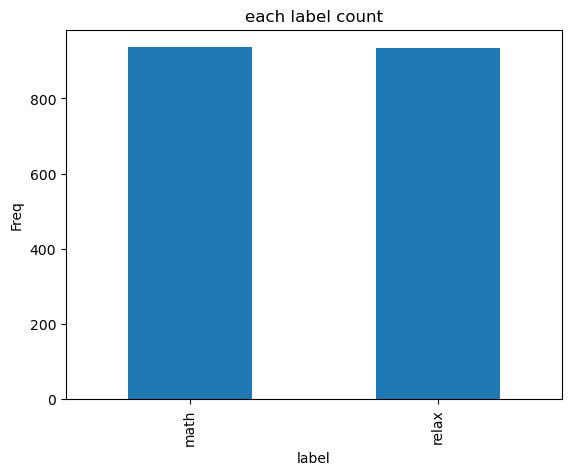

In [ ]:
#plot the count of each label.
df_outer.label.value_counts().plot(kind='bar', title="each label count", xlabel="label", ylabel="Freq")

### plot the frequency distribution of each categorical entry in each categorical feature regrading to the label and the ID feature.

<AxesSubplot: xlabel='Session', ylabel='Freq'>

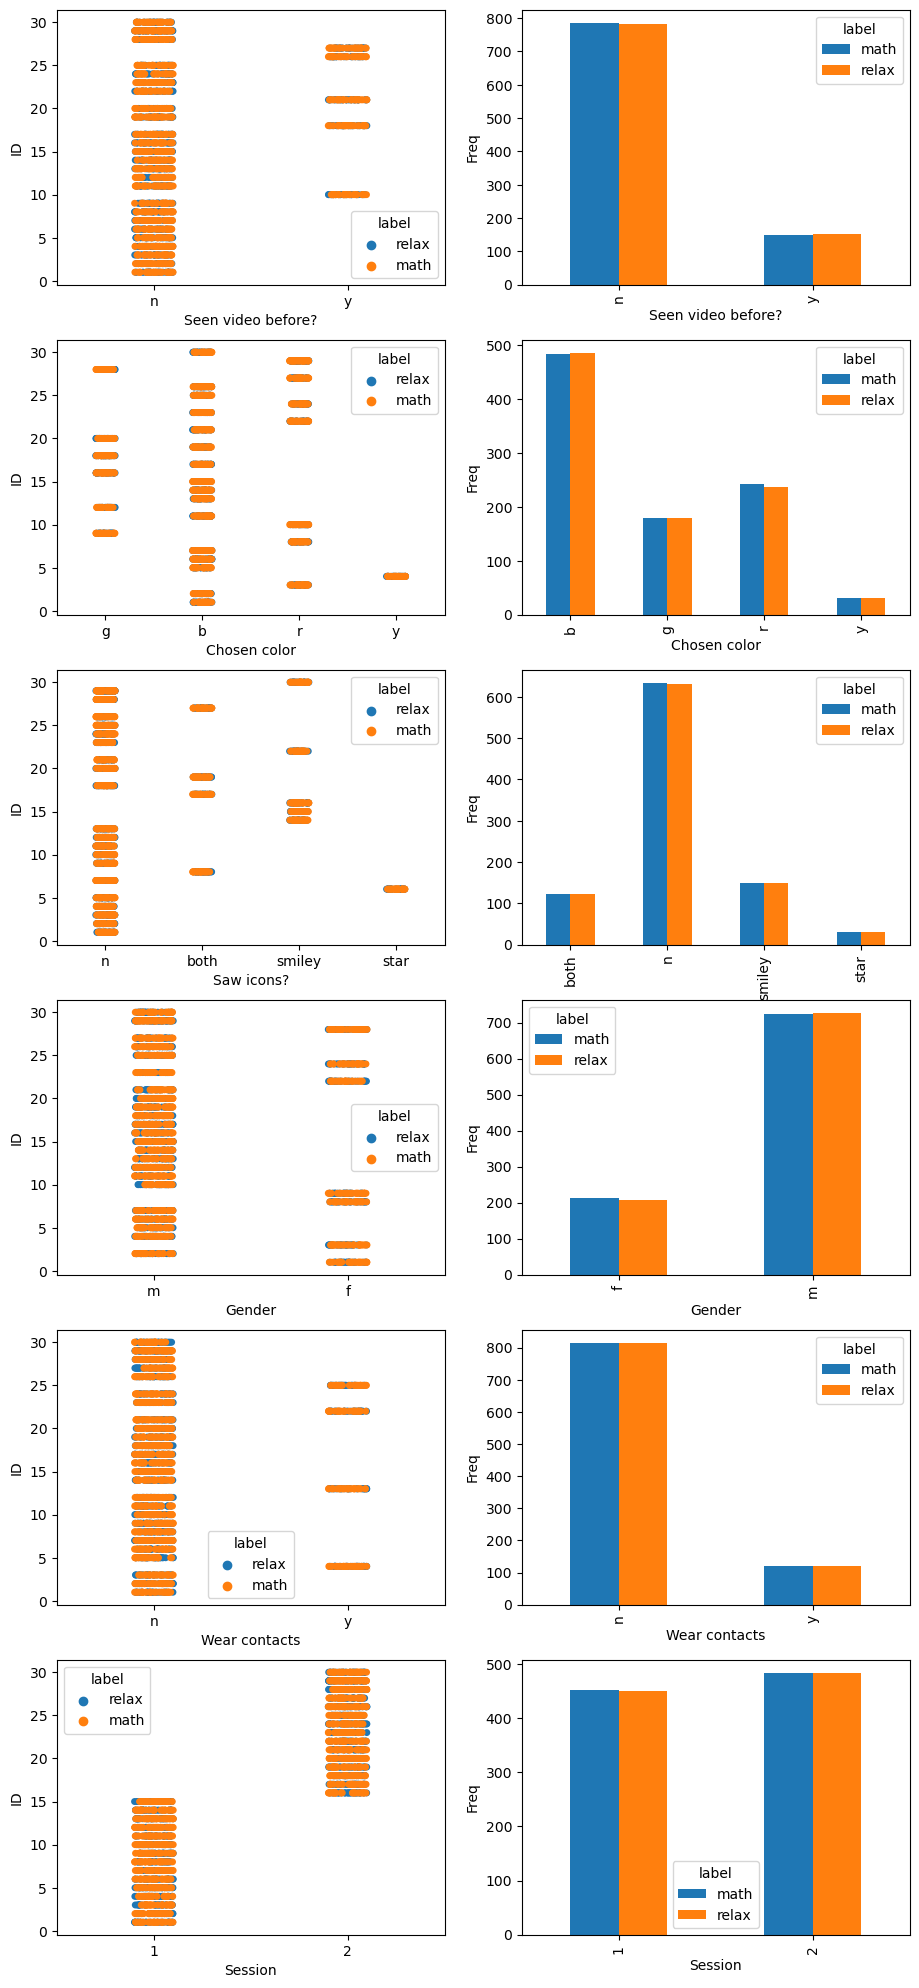

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(6,2, figsize=(11,25))


#Seen video before?
sns.stripplot(data = df_outer, x = 'Seen video before?', y='ID', hue='label', ax = ax1)
pd.crosstab(df_outer['Seen video before?'],df_outer.label).plot(kind='bar', ylabel='Freq', ax=ax2)

#Chosen color
sns.stripplot(data = df_outer, x = 'Chosen color', y='ID', hue='label', ax = ax3)
pd.crosstab(df_outer['Chosen color'],df_outer.label).plot(kind='bar', ylabel="Freq",ax=ax4)

#Saw icons?
sns.stripplot(data = df_outer, x = 'Saw icons?', y='ID', hue='label', ax = ax5)
pd.crosstab(df_outer['Saw icons?'],df_outer.label).plot(kind='bar', ylabel="Freq", ax=ax6)

#Gender
sns.stripplot(data = df_outer, x = 'Gender', y='ID', hue='label', ax = ax7)
pd.crosstab(df_outer['Gender'],df_outer.label).plot(kind='bar', ylabel="Freq", ax=ax8)

#Wear contacts
sns.stripplot(data = df_outer, x = 'Wear contacts', y='ID', hue='label', ax = ax9)
pd.crosstab(df_outer['Wear contacts'],df_outer.label).plot(kind='bar', ylabel="Freq", ax=ax10)

df_outer = df_outer.astype({'Session': 'category'})
sns.stripplot(data = df_outer, x = 'Session', y='ID', hue='label', ax = ax11)
pd.crosstab(df_outer['Session'],df_outer.label).plot(kind='bar', ylabel="Freq", ax = ax12)


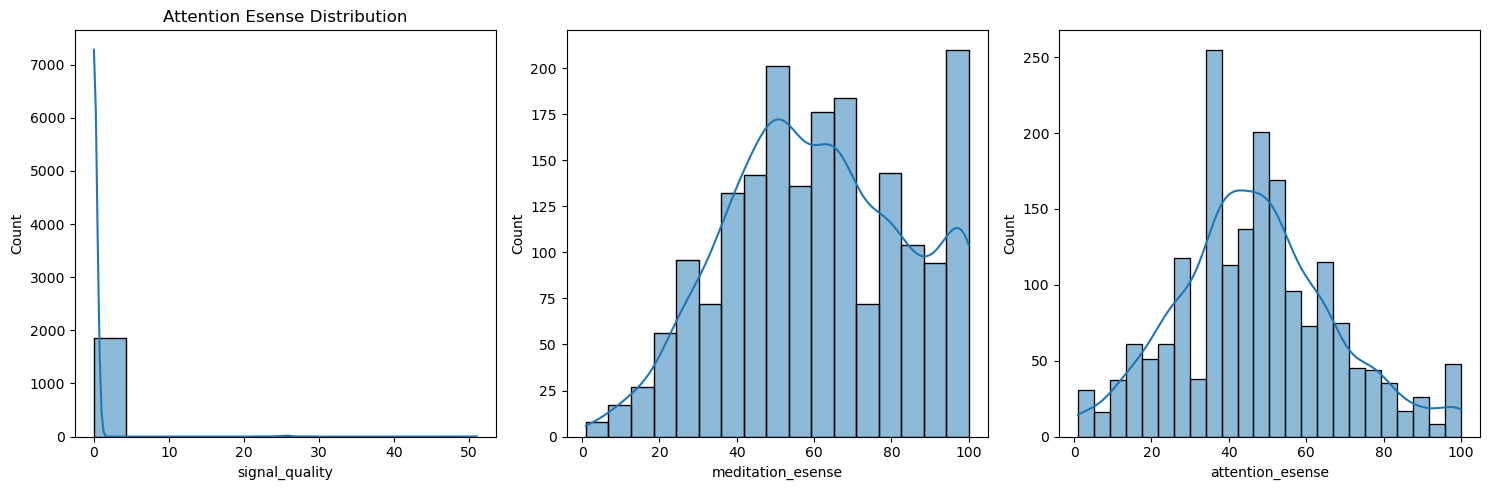

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(15,5))


#signal_quality
ax1.set_title("Signal Quality Distribution")
ax1.set_title("Meditaition Esense Distribution")
ax1.set_title("Attention Esense Distribution")

sns.histplot(data = df_outer, x = 'signal_quality', kde=True, ax = ax1)
sns.histplot(data = df_outer, x = 'meditation_esense', kde=True, ax = ax2)
sns.histplot(data = df_outer, x = 'attention_esense', kde=True, ax = ax3)
plt.tight_layout()

### plot the pair scatteplot of each feature in the egg_power feature.

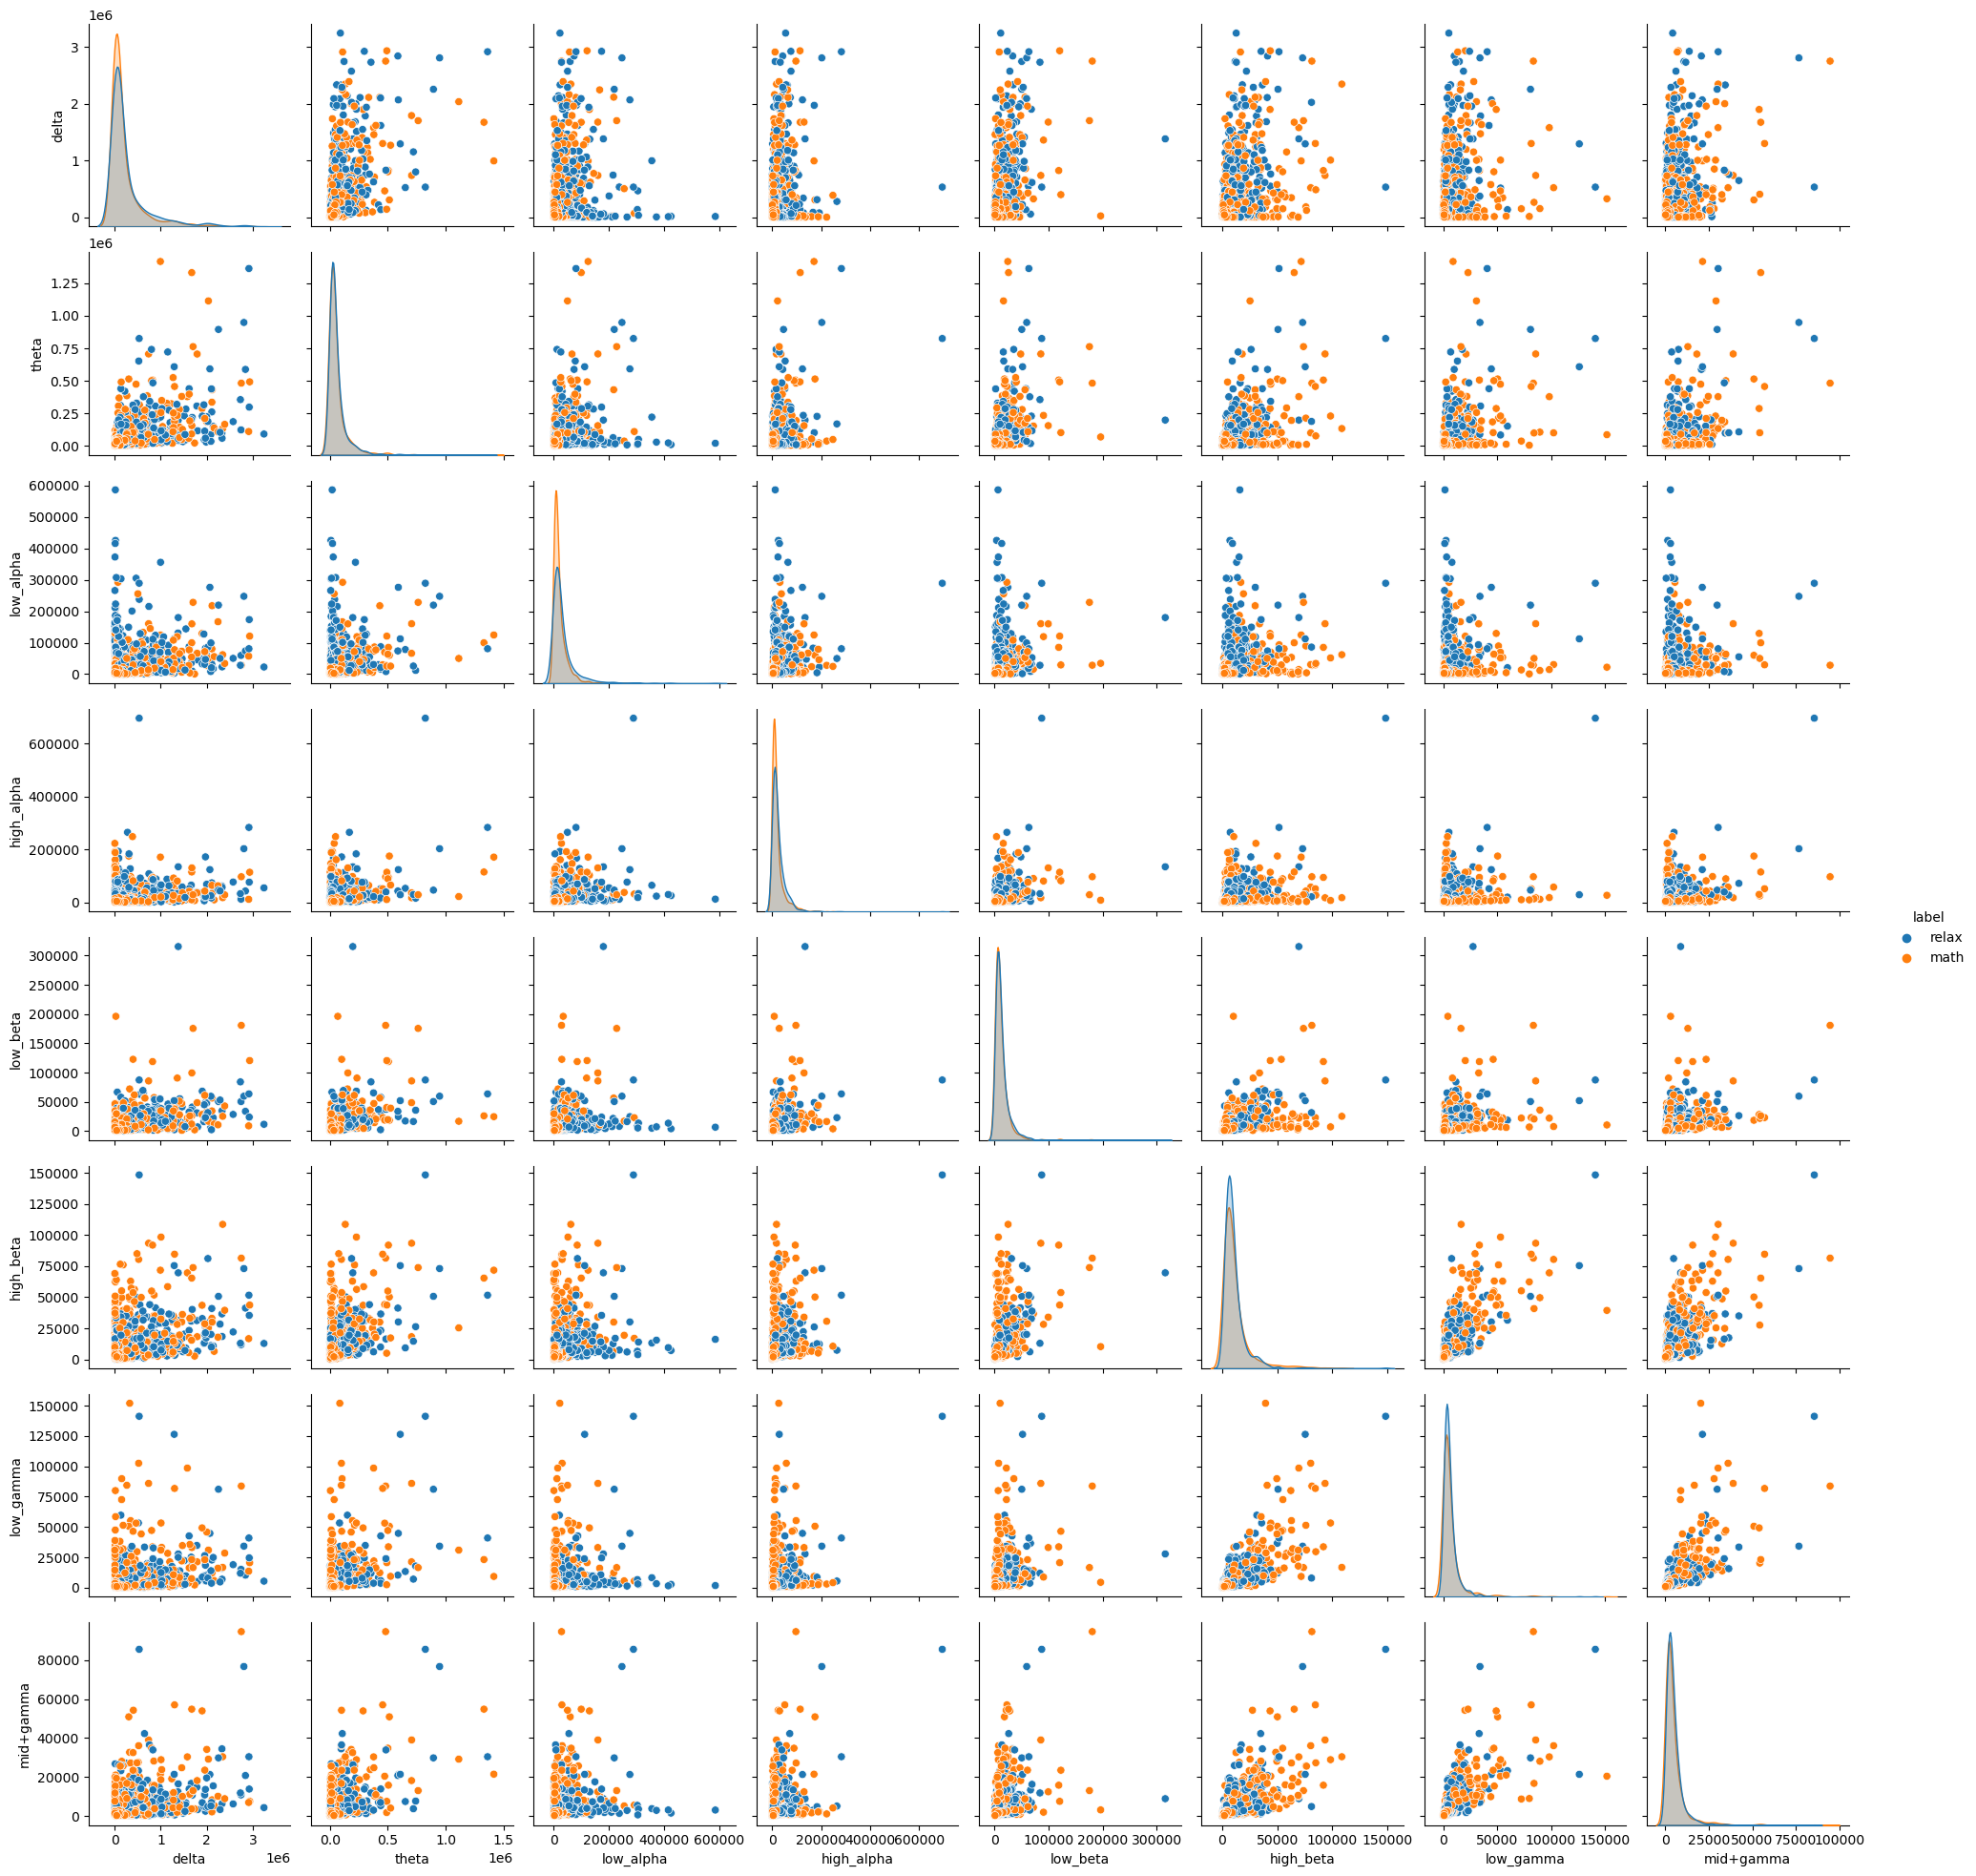

In [ ]:
#divide the list into 5 features
egg_features_to_plot = pd.DataFrame(df_outer['eeg_power'].tolist())
#rename the columns
egg_features_to_plot.columns = ['delta','theta','low_alpha','high_alpha','low_beta','high_beta','low_gamma','mid+gamma']
#merge the columns with the label column.
sns.pairplot(pd.concat([egg_features_to_plot, df_outer['label'].reset_index(drop=True)], axis = 1), hue = 'label')

### plot the frequency of the browser_latency values in a pie graph.

array([<AxesSubplot: ylabel='browser_latency'>], dtype=object)

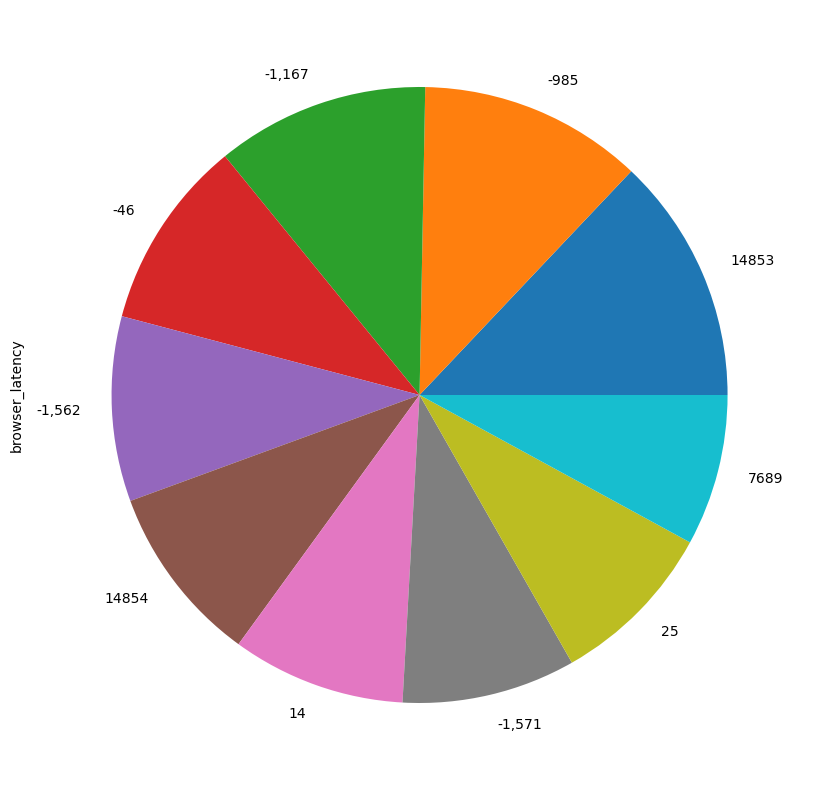

In [ ]:
df_outer.browser_latency.value_counts().to_frame().iloc[0:10].plot(kind='pie', subplots=True, legend=False, figsize=(15, 10))

## Features engineering.

### convert the browser_latency datatype to float.

In [ ]:
#replace the , inside each sample in browser_latency with .
df_outer.loc[:,'browser_latency'] = df_outer.browser_latency.apply(lambda x: x.replace(',','.')).copy()
#convert the datatype of browser_latency to float32
df_outer = df_outer.astype({'browser_latency': 'float32'})

### convert the data type of **'Seen video before?','Chosen color','Saw icons?','Gender','Wear contacts','label'** to categorical.

In [ ]:
df_outer[['Seen video before?','Chosen color','Saw icons?','Gender','Wear contacts','label']] = df_outer[['Seen video before?','Chosen color','Saw icons?','Gender','Wear contacts','label']].astype('category')

In [ ]:
df_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1870 entries, 1157 to 29709
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Unnamed: 0          1870 non-null   int64   
 1   id                  1870 non-null   int64   
 2   indra_time          1870 non-null   object  
 3   browser_latency     1870 non-null   float32 
 4   reading_time        1870 non-null   object  
 5   attention_esense    1870 non-null   int64   
 6   meditation_esense   1870 non-null   int64   
 7   eeg_power           1870 non-null   object  
 8   raw_values          1870 non-null   object  
 9   signal_quality      1870 non-null   int64   
 10  createdAt           1870 non-null   object  
 11  updatedAt           1870 non-null   object  
 12  label               1870 non-null   category
 13  ID                  1870 non-null   int64   
 14  Session             1870 non-null   category
 15  Seen video before?  1870 non-null 

In [ ]:
#convert them to dummy encoded data.
OHE_data = pd.get_dummies(df_outer.iloc[:,-6:], columns=['Session','Seen video before?','Chosen color','Saw icons?','Gender','Wear contacts'])

In [ ]:
OHE_data

,Session_1,Session_2,Seen video before?_n,Seen video before?_y,Chosen color_b,Chosen color_g,Chosen color_r,Chosen color_y,Saw icons?_both,Saw icons?_n,Saw icons?_smiley,Saw icons?_star,Gender_f,Gender_m,Wear contacts_n,Wear contacts_y
1157,1,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0
1158,1,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0
1159,1,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0
1160,1,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0
1161,1,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29705,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0
29706,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0
29707,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0
29708,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0


In [ ]:
#frop the old features.
df_outer = df_outer.drop(['Session','Seen video before?','Chosen color','Saw icons?','Gender','Wear contacts'], axis = 1)
#append the new encoded features to the data frame.
df_outer = pd.concat([df_outer, OHE_data], axis = 1)

### convert the labels to 0 and 1.

In [ ]:
#store the labels to the new variable.
df_output = df_outer['label']
#drop them from the original dataframe.
df_outer = df_outer.drop(['label'],axis=1)
#convert their values to 0 and 1.
df_output = df_output.map(dict(relax=0, math=1))
df_output

1157     0
1158     0
1159     0
1160     0
1161     0
        ..
29705    1
29706    1
29707    1
29708    1
29709    1
Name: label, Length: 1870, dtype: category
Categories (2, int64): [1, 0]

### Take the median of each list the egg_power feature.

In [ ]:
#create egg_features median.
egg_features = [np.median(df_outer.iloc[i]['eeg_power']) for i in range(len(df_outer))]
eeg_features=pd.DataFrame(egg_features) #series to list and then back to df
eeg_features

,0
0,34994.5
1,11393.5
2,13324.5
3,5829.0
4,16030.0
...,...
1865,6546.0
1866,1589.0
1867,2822.0
1868,5241.0


In [ ]:
df_outer.reset_index(drop=True, inplace=True)
eeg_features.reset_index(drop=True, inplace=True)
#concat median features with the main dataframe.
df_outer = pd.concat([df_outer, eeg_features], axis=1) # concatenate the create columns
df_outer = df_outer.rename(columns = {0: 'egg features median'})

### convert raw values to fourir dimenstion and take the log 10 from each list.

In [ ]:
#REF:- https://www.kaggle.com/code/elsehow/classifying-relaxation-versus-doing-math/notebook
def spectrum (vector):
    '''get the power spectrum of a vector of raw EEG data'''
    A = np.fft.fft(vector)
    ps = np.abs(A)**2
    ps = ps[:len(ps)//2]
    return ps


def binned (pspectra, n):
    '''compress an array of power spectra into vectors of length n'''
    l = len(pspectra)
    array = np.zeros([l,n])
    for i,ps in enumerate(pspectra):
        x = np.arange(1,len(ps)+1)
        f = interp1d(x,ps)#/np.sum(ps))
        array[i] = f(np.arange(1, n+1))
    index = np.argwhere(array[:,0]==-1)
    array = np.delete(array,index,0)
    return array

def feature_vector(readings, bins=200): # A function we apply to each group of power spectra
  '''
  Create 100, log10-spaced bins for each power spectrum.
  For more on how this particular implementation works, see:
  http://coolworld.me/pre-processing-EEG-consumer-devices/
  '''
  bins = binned(list(map(spectrum, readings)), bins)
  return np.log10(np.mean(bins, 0))

def grouper(n, iterable, fillvalue=None):
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

def vectors (df):
    return [feature_vector(group) for group in list(grouper(1, df.raw_values.tolist()))]

In [ ]:
raws_values = np.array(vectors(df_outer))
raws_values = np.median(raws_values,axis=1)
raw_features=pd.DataFrame(raws_values) #series to list and then back to df
raw_features
raw_features = raw_features.rename(columns = {0:'raws values median'})
raw_features
df_outer = pd.concat([df_outer, raw_features], axis=1) # concatenate the create columns

In [ ]:
df_outer.reset_index(drop=True, inplace=True)
raw_features.reset_index(drop=True, inplace=True)

In [ ]:
df_outer = df_outer.drop(['id','raw_values','eeg_power', 'Unnamed: 0', 'indra_time','reading_time', 'updatedAt', 'createdAt'], axis=1)

In [ ]:
#df_outer[df_outer.columns.difference(['ID'])] =(df_outer[df_outer.columns.difference(['ID'])]-df_outer[df_outer.columns.difference(['ID'])].min())/(df_outer[df_outer.columns.difference(['ID'])].max()-df_outer[df_outer.columns.difference(['ID'])].min())
std_scaler = StandardScaler()
df_outer[df_outer.columns.difference(['ID'])] = std_scaler.fit_transform(df_outer[df_outer.columns.difference(['ID'])])

In [ ]:
df_outer

,browser_latency,attention_esense,meditation_esense,signal_quality,ID,Session_1,Session_2,Seen video before?_n,Seen video before?_y,Chosen color_b,...,Saw icons?_both,Saw icons?_n,Saw icons?_smiley,Saw icons?_star,Gender_f,Gender_m,Wear contacts_n,Wear contacts_y,egg features median,raws values median
0,-0.267552,-0.293340,-0.910444,-0.062893,12,1.034831,-1.034831,0.437998,-0.437998,-1.037050,...,-0.38829,0.690719,-0.436262,-0.182069,-0.53737,0.53737,0.38555,-0.38555,1.557285,-0.068176
1,-0.267552,-1.121296,-0.568768,-0.062893,12,1.034831,-1.034831,0.437998,-0.437998,-1.037050,...,-0.38829,0.690719,-0.436262,-0.182069,-0.53737,0.53737,0.38555,-0.38555,-0.138145,-0.041331
2,-0.267552,0.047583,-0.739606,-0.062893,12,1.034831,-1.034831,0.437998,-0.437998,-1.037050,...,-0.38829,0.690719,-0.436262,-0.182069,-0.53737,0.53737,0.38555,-0.38555,0.000573,-0.283415
3,-0.267552,0.437210,-0.056253,-0.062893,12,1.034831,-1.034831,0.437998,-0.437998,-1.037050,...,-0.38829,0.690719,-0.436262,-0.182069,-0.53737,0.53737,0.38555,-0.38555,-0.537883,-0.050904
4,-0.267552,0.047583,-0.440639,-0.062893,12,1.034831,-1.034831,0.437998,-0.437998,-1.037050,...,-0.38829,0.690719,-0.436262,-0.182069,-0.53737,0.53737,0.38555,-0.38555,0.194928,-0.019610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,-0.274205,1.362573,-0.312510,-0.062893,21,-0.966342,0.966342,-2.283117,2.283117,0.964274,...,-0.38829,0.690719,-0.436262,-0.182069,-0.53737,0.53737,0.38555,-0.38555,-0.486376,0.158204
1866,-0.274205,0.193693,-0.867734,-0.062893,21,-0.966342,0.966342,-2.283117,2.283117,0.964274,...,-0.38829,0.690719,-0.436262,-0.182069,-0.53737,0.53737,0.38555,-0.38555,-0.842473,-1.181229
1867,-0.274205,0.485913,-1.337539,-0.062893,21,-0.966342,0.966342,-2.283117,2.283117,0.964274,...,-0.38829,0.690719,-0.436262,-0.182069,-0.53737,0.53737,0.38555,-0.38555,-0.753898,-1.175056
1868,-0.274188,0.193693,-1.380249,-0.062893,21,-0.966342,0.966342,-2.283117,2.283117,0.964274,...,-0.38829,0.690719,-0.436262,-0.182069,-0.53737,0.53737,0.38555,-0.38555,-0.580123,-1.118098


## Machine learning models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_outer.values, df_output.values, stratify=df_output, shuffle=True, train_size=0.8, random_state=1)
X_train

array([[-0.2740149 , -0.34204311, -0.61147711, ..., -0.3855498 ,
         0.94357996,  0.54092907],
       [-0.2780294 ,  2.09312257, -2.02089155, ..., -0.3855498 ,
        -0.09795203,  1.24774034],
       [-0.27822231, -0.2933398 , -0.56876759, ..., -0.3855498 ,
         0.30383356, -0.22816598],
       ...,
       [-0.27423971, -0.58555968,  0.58438968, ..., -0.3855498 ,
        -0.46065818, -0.95873774],
       [-0.27401321,  1.36257286, -1.0385724 , ..., -0.3855498 ,
        -0.30577712, -0.62488766],
       [-0.27401491, -0.43944974, -1.3375391 , ..., -0.3855498 ,
         0.91700019, -0.35234645]])

### Create machine learning models.

In [ ]:
classifiers = [
    LogisticRegression(solver="saga", random_state=1, max_iter= 10000000),
    LinearSVC(random_state=1, max_iter= 10000000),
    SVC(kernel='poly', degree=10),
    RandomForestClassifier(random_state=1),
    XGBClassifier(random_state=1),
    MLPClassifier(
        random_state=1,
        solver="adam",
        hidden_layer_sizes=(64, 32, 18),
        activation="relu",
        early_stopping=True,
        n_iter_no_change=1,
    ),
    GradientBoostingClassifier(random_state=2)
]

In [ ]:
names = [re.match(r"[^\(]+", name.__str__())[0] for name in classifiers]
print(f"Classifiers to test: {names}")

Classifiers to test: ['LogisticRegression', 'LinearSVC', 'SVC', 'RandomForestClassifier', 'XGBClassifier', 'MLPClassifier', 'GradientBoostingClassifier']


### Train and evaluate each model and plot the confusion matrxi of each model.

Training classifier: LogisticRegression.

classification_report for LogisticRegression.
              precision    recall  f1-score   support

           0       0.60      0.57      0.58       187
           1       0.59      0.61      0.60       187

    accuracy                           0.59       374
   macro avg       0.59      0.59      0.59       374
weighted avg       0.59      0.59      0.59       374



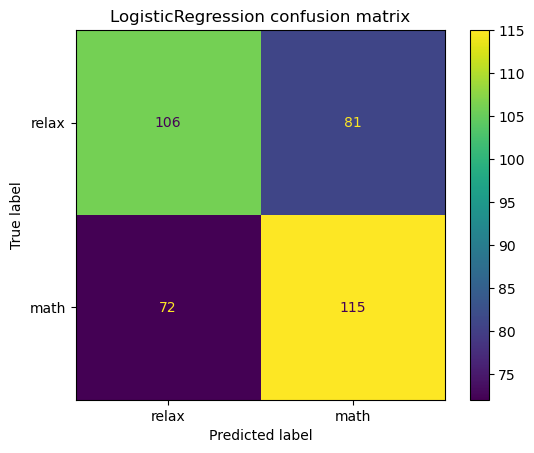




Training classifier: LinearSVC.

classification_report for LinearSVC.
              precision    recall  f1-score   support

           0       0.60      0.57      0.58       187
           1       0.59      0.62      0.60       187

    accuracy                           0.59       374
   macro avg       0.59      0.59      0.59       374
weighted avg       0.59      0.59      0.59       374



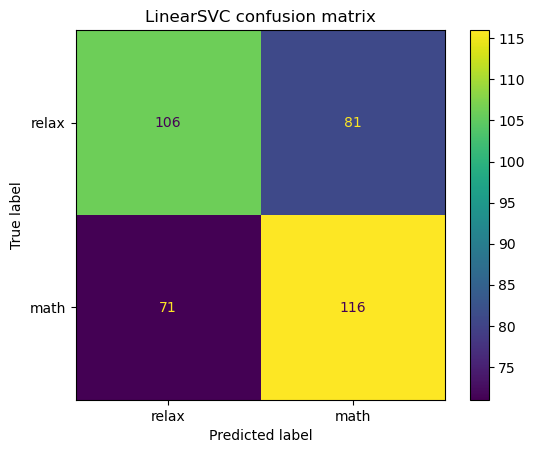




Training classifier: SVC.

classification_report for SVC.
              precision    recall  f1-score   support

           0       0.56      0.90      0.69       187
           1       0.74      0.29      0.42       187

    accuracy                           0.59       374
   macro avg       0.65      0.59      0.55       374
weighted avg       0.65      0.59      0.55       374



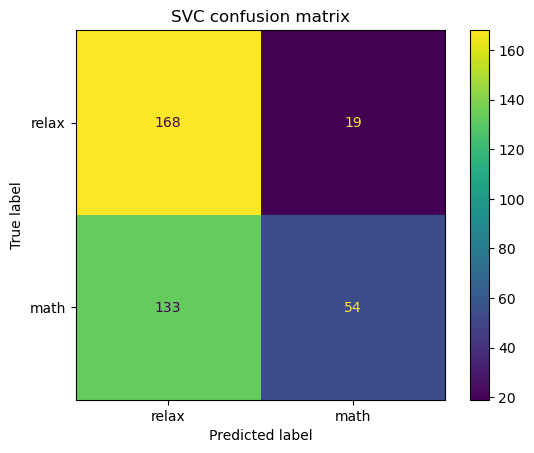




Training classifier: RandomForestClassifier.

classification_report for RandomForestClassifier.
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       187
           1       0.88      0.89      0.89       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.89       374
weighted avg       0.89      0.89      0.89       374



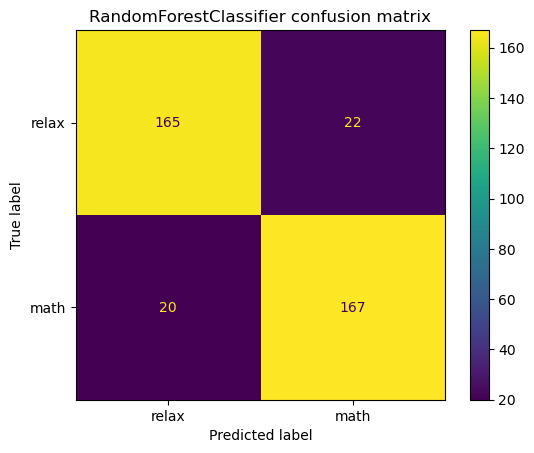




Training classifier: XGBClassifier.

classification_report for XGBClassifier.
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       187
           1       0.89      0.85      0.87       187

    accuracy                           0.87       374
   macro avg       0.88      0.87      0.87       374
weighted avg       0.88      0.87      0.87       374



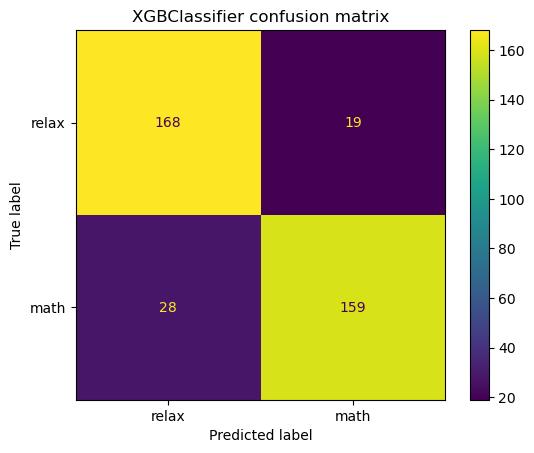




Training classifier: MLPClassifier.

classification_report for MLPClassifier.
              precision    recall  f1-score   support

           0       0.59      0.60      0.59       187
           1       0.59      0.57      0.58       187

    accuracy                           0.59       374
   macro avg       0.59      0.59      0.59       374
weighted avg       0.59      0.59      0.59       374



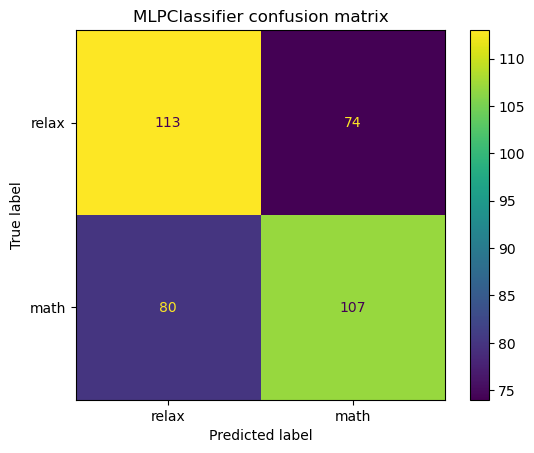




Training classifier: GradientBoostingClassifier.

classification_report for GradientBoostingClassifier.
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       187
           1       0.81      0.81      0.81       187

    accuracy                           0.81       374
   macro avg       0.81      0.81      0.81       374
weighted avg       0.81      0.81      0.81       374



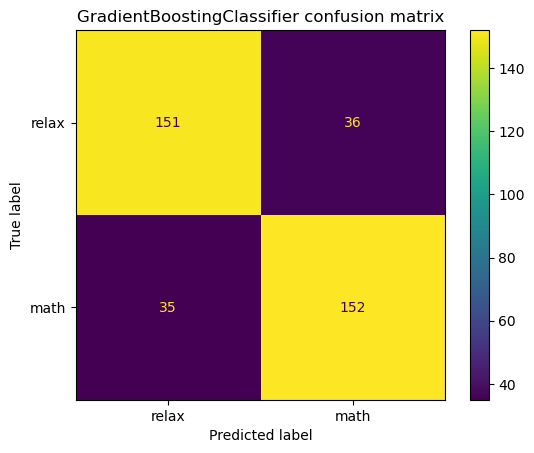




Wall time: 4.05 s


In [ ]:
%%time
# test all classifiers and save pred. results on test data
for name, clf in zip(names, classifiers):
    print(f"Training classifier: {name}.")
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    report = classification_report(y_test, prediction)
    print(f"\nclassification_report for {name}.")
    print(report)
    cm = confusion_matrix(y_test, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['relax', 'math'])
    disp.plot()
    disp.ax_.set_title(f"{name} confusion matrix")
    plt.show()
    print('\n\n')

In [ ]:
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['model']

### Tune the hyperparameters of the random forest classifier

In [ ]:
#define hyperparameter for the random forest model.
space={ 'max_depth': hp.quniform("max_depth", 2, 10, 1),
        "max_leaf_nodes": hp.choice("max_leaf_nodes", [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]),
        "criterion" : hp.choice("criterion",['gini','entropy']),
        "min_samples_split" : hp.choice("min_samples_split",[2,3,4,5,6,7]),
        "min_samples_leaf" : hp.choice("min_samples_leaf",[1,2,3,4,5,6]),
        "max_features": hp.choice("max_features", ['sqrt', 'log2', None]),
        "min_weight_fraction_leaf": hp.uniform('min_weight_fraction_leaf', 0.0,0.5),
        'seed': 0
    }

In [ ]:
#function to train and test the model with the given parameters.
tuned_rf_results = []
def random_forest_hyperparameter_tuning(space):
    model = RandomForestClassifier(max_depth = int(space['max_depth']), max_leaf_nodes = space['max_leaf_nodes'], criterion=space['criterion'], min_samples_split=space['min_samples_split'], min_samples_leaf=space['min_samples_leaf'], max_features=space['max_features'],min_weight_fraction_leaf = space['min_weight_fraction_leaf'], n_jobs = -1)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    f1 = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    tuned_rf_results.append(accuracy)
    print (f"ACCURACY: {accuracy}, F1_SCORE: {f1}, PRECISION {precision}, RECALL {recall}." )
    #negative sign to the accuracy because we are measuring the loss.
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [ ]:
%time
trials = Trials()
#start search.
max_evals = 2000
best_rf_params = fmin(fn=random_forest_hyperparameter_tuning,space=space,algo=tpe.suggest,max_evals=max_evals,trials=trials)

Wall time: 0 ns
ACCURACY: 0.6176470588235294, F1_SCORE: 0.6416040100250626, PRECISION 0.6037735849056604, RECALL 0.6844919786096256.
ACCURACY: 0.6470588235294118, F1_SCORE: 0.6544502617801048, PRECISION 0.6410256410256411, RECALL 0.6684491978609626.
ACCURACY: 0.6176470588235294, F1_SCORE: 0.6433915211970075, PRECISION 0.602803738317757, RECALL 0.6898395721925134.
ACCURACY: 0.5989304812834224, F1_SCORE: 0.592391304347826, PRECISION 0.6022099447513812, RECALL 0.5828877005347594.
ACCURACY: 0.606951871657754, F1_SCORE: 0.618181818181818, PRECISION 0.601010101010101, RECALL 0.6363636363636364.
ACCURACY: 0.6443850267379679, F1_SCORE: 0.671604938271605, PRECISION 0.6238532110091743, RECALL 0.7272727272727273.
ACCURACY: 0.6470588235294118, F1_SCORE: 0.6683417085427136, PRECISION 0.6303317535545023, RECALL 0.7112299465240641.
ACCURACY: 0.6042780748663101, F1_SCORE: 0.6185567010309279, PRECISION 0.5970149253731343, RECALL 0.6417112299465241.
ACCURACY: 0.5962566844919787, F1_SCORE: 0.603674540682

In [ ]:
print(f"Best parameters for random forest models is {best_rf_params}")

Best parameters for random forest models is {'criterion': 0, 'max_depth': 10.0, 'max_features': 0, 'max_leaf_nodes': 0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0005283874719911728}


              precision    recall  f1-score   support

           0       0.88      0.93      0.90       187
           1       0.92      0.88      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



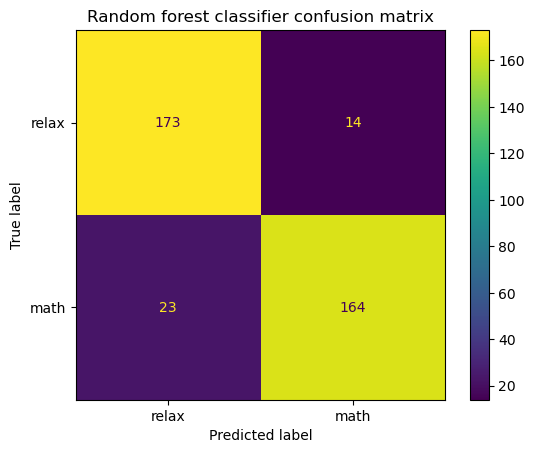

Text(0, 0.5, 'Accuracy')

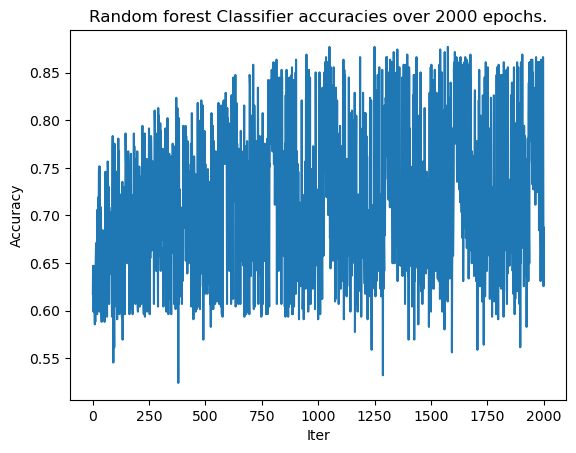

In [ ]:
#check the XG boosting model performance.
tuned_rf_model = getBestModelfromTrials(trials)
pred = tuned_rf_model.predict(X_test)
print(classification_report(y_test, pred > 0.5))
cm = confusion_matrix(y_test, pred > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['relax', 'math'])
disp.plot()
disp.ax_.set_title(f"Random forest classifier confusion matrix")
plt.show()


plt.plot(np.arange(1,max_evals+1), tuned_rf_results)
plt.title(f"Random forest Classifier accuracies over {max_evals} epochs.")
plt.xlabel("Iter")
plt.ylabel("Accuracy")


### Tune the hyperparameters of XG boosting classifier

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform('gamma', 1,9),
        'reg_alpha' : hp.choice('reg_alpha', [0,0.001,0.1,0.5,1,1.5,5,10]),
        'reg_lambda' : hp.choice('reg_lambda', [0,0.001,0.1,0.5,1,1.5,5,10]),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        "learning_rate" :hp.uniform('learning_rate', 0.001,1.5),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        "max_leaves": hp.choice("max_leaves", [0, 1, 2, 3, 4,5,6,7,8,9,10]),
        'seed': 0
    }

In [ ]:
#function to train and test the model with the given parameters.
tuned_xgb_results = []
def XGB_hyperparameter_tuning(space):
    model = XGBClassifier(max_leaves = space['max_leaves'], max_depth = int(space['max_depth']), gamma = space['gamma'],reg_alpha = space['reg_alpha'], reg_lambda = space['reg_lambda'],min_child_weight=space['min_child_weight'],colsample_bytree=space['colsample_bytree'], learning_rate = space['learning_rate'])
    evaluation =[(X_test, y_train), ( X_train, y_test)]

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    f1 = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    tuned_xgb_results.append(accuracy)
    print (f"ACCURACY: {accuracy}, F1_SCORE: {f1}, PRECISION {precision}, RECALL {recall}." )
    #negative sign to the accuracy because we are measuring the loss.
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [ ]:
%time
trials = Trials()
#start search
best_XGB_params = fmin(fn=XGB_hyperparameter_tuning,space=space,algo=tpe.suggest,max_evals=max_evals,trials=trials)
print(f"Best parameters for this models is {best_XGB_params}")

Wall time: 0 ns
ACCURACY: 0.839572192513369, F1_SCORE: 0.8404255319148936, PRECISION 0.8359788359788359, RECALL 0.8449197860962567.
ACCURACY: 0.8288770053475936, F1_SCORE: 0.8279569892473118, PRECISION 0.8324324324324325, RECALL 0.8235294117647058.
ACCURACY: 0.8315508021390374, F1_SCORE: 0.8254847645429363, PRECISION 0.8563218390804598, RECALL 0.7967914438502673.
ACCURACY: 0.8556149732620321, F1_SCORE: 0.8508287292817679, PRECISION 0.88, RECALL 0.8235294117647058.
ACCURACY: 0.8475935828877005, F1_SCORE: 0.8471849865951744, PRECISION 0.8494623655913979, RECALL 0.8449197860962567.
ACCURACY: 0.7459893048128342, F1_SCORE: 0.7493403693931399, PRECISION 0.7395833333333334, RECALL 0.7593582887700535.
ACCURACY: 0.7754010695187166, F1_SCORE: 0.7754010695187166, PRECISION 0.7754010695187166, RECALL 0.7754010695187166.
ACCURACY: 0.8128342245989305, F1_SCORE: 0.8128342245989305, PRECISION 0.8128342245989305, RECALL 0.8128342245989305.
ACCURACY: 0.7754010695187166, F1_SCORE: 0.776595744680851, PREC

In [ ]:
print(f"Best parameters for XG boosting classifier model is {best_XGB_params}")

Best parameters for XG boosting classifier model is {'colsample_bytree': 0.7568261814778421, 'gamma': 1.415498008273543, 'learning_rate': 0.25910051991768834, 'max_depth': 10.0, 'max_leaves': 2, 'min_child_weight': 0.0, 'reg_alpha': 3, 'reg_lambda': 0}


              precision    recall  f1-score   support

           0       0.88      0.93      0.90       187
           1       0.92      0.88      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



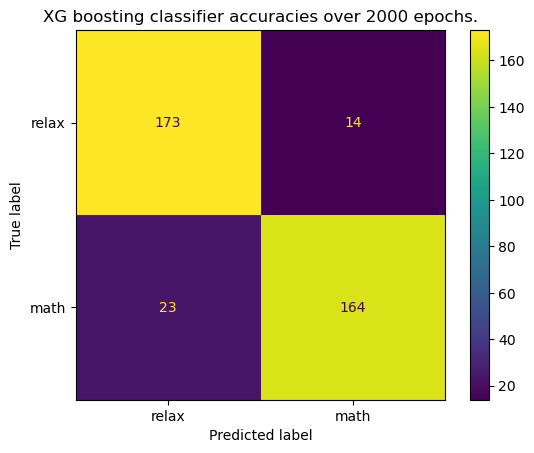

Text(0, 0.5, 'Accuracy')

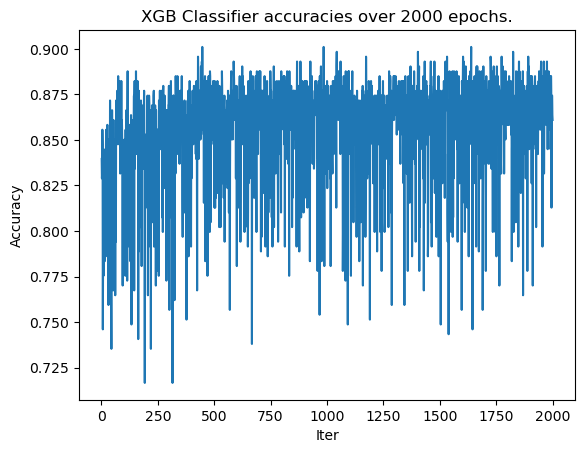

In [ ]:
#check the XG boosting model performance.
tuned_xgboosting_model = getBestModelfromTrials(trials)
pred = tuned_xgboosting_model.predict(X_test)
print(classification_report(y_test, pred > 0.5))
cm = confusion_matrix(y_test, pred > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['relax', 'math'])
disp.plot()
plt.title(f"XG boosting classifier accuracies over {max_evals} epochs.")
plt.show()
plt.plot(np.arange(1,max_evals+1), tuned_xgb_results)
plt.title(f"XGB Classifier accuracies over {max_evals} epochs.")
plt.xlabel("Iter")
plt.ylabel("Accuracy")

## Deep Learning model.

In [ ]:
def create_ANN(hyperparameter):
  """
  function to create model that tuner will search for best hyperparameter within this model.
  build a neural network archeticture.
  """
  #search for best learning rate
  LR = hyperparameter.Float('learning_rate',min_value=1e-5,max_value=0.1,sampling='LOG',default=1e-3)
  #search for best hidden units number for first hidden layer
  hidden_neurons_1 = hyperparameter.Int('hidden_units_1',min_value=32,max_value=512,step=32,default=128)
  #search for best hidden units number for second hidden layer
  hidden_neurons_2 = hyperparameter.Int('hidden_units_2',min_value=32,max_value=512,step=32,default=128)
  #search for best dropout rate
  hidden_dropout =  hyperparameter.Float('hidden_dropout',min_value=0.0,max_value=0.5,default=0.25,step=0.05)
  #search for l1 reguralization for the first hidden units values
  l1_penalty_hidden_1 = hyperparameter.Float('l1_penalty_hidden_1',min_value=0.0,max_value=0.01,default=0.0,step=0.0015)
  #search for l2 reguralization for the first hidden units values
  l2_penalty_hidden_1 = hyperparameter.Float('l2_penalty_hidden_1',min_value=0.0,max_value=0.01,default=0.0,step=0.0015)
  #search for l2 reguralization for the first hidden layer bias value
  l2_penalty_hidden_bias_1 = hyperparameter.Float('l2_penalty_hidden_bias_1',min_value=0.0,max_value=0.01,default=0.0,step=0.0015)

  l1_penalty_hidden_2 = hyperparameter.Float('l1_penalty_hidden_2',min_value=0.0,max_value=0.01,default=0.0,step=0.0015)
  #search for l2 reguralization for the first hidden units values
  l2_penalty_hidden_2 = hyperparameter.Float('l2_penalty_hidden_2',min_value=0.0,max_value=0.01,default=0.0,step=0.0015)
  #search for l2 reguralization for the first hidden layer bias value
  l2_penalty_hidden_bias_2 = hyperparameter.Float('l2_penalty_hidden_bias_2',min_value=0.0,max_value=0.01,default=0.0,step=0.0015)


  #create your model
  df_input = keras.Input(shape = df_outer.shape[1])
  fused1 = Dense(hidden_neurons_1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_penalty_hidden_1, l2=l2_penalty_hidden_1), bias_regularizer=regularizers.l2(l2_penalty_hidden_bias_1))(df_input)
  dropout_1 = Dropout(rate = hidden_dropout)(fused1)
  fused_2 = Dense(hidden_neurons_2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_penalty_hidden_2, l2=l2_penalty_hidden_2), bias_regularizer=regularizers.l2(l2_penalty_hidden_bias_2))(dropout_1)
  fused_3 = Dense(hidden_neurons_2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_penalty_hidden_2, l2=l2_penalty_hidden_2), bias_regularizer=regularizers.l2(l2_penalty_hidden_bias_2))(fused_2)


  # define model input/output using keys.
  model = keras.Model(df_input,fused_3)
  optimizer = Adam(learning_rate=LR)
  model.compile(optimizer=Adam(learning_rate = LR),loss = 'sparse_categorical_crossentropy',metrics='SparseCategoricalAccuracy')

  print(model.summary())
  return model

### search for the best hyperparameters for the deep learning model.

In [ ]:
tuner = kt.Hyperband(create_ANN,
                     objective='val_sparse_categorical_accuracy',
                     max_epochs=100,
                     directory='my_dir',
                     factor = 3,
                     project_name='Rakesh',
                     overwrite = True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense (Dense)               (None, 128)               3072      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
Total params: 36,096
Trainable params: 36,096
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
start_time = time()

#search for best hyperparameters to find best validation accuracy
tuner.search(X_train, np.array(y_train), epochs=200, validation_split = 0.2 ,use_multiprocessing=True, workers=6, callbacks=[stop_early])

# Get the optimal hyperparameters after finishing the search
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] #get the number 1 best hyperparametes

print("\t\t\t\t\t\tThe best hyperparameters search is complete.\n")
print(f"The optimal number of units in the first hidden layer is {best_hps.get('hidden_units_1')}, the best dropout in this layer is {best_hps.get('hidden_dropout')}, best L1 and L2 regulaizers values are ({best_hps.get('l1_penalty_hidden_1')},{best_hps.get('l2_penalty_hidden_1')},{best_hps.get('l2_penalty_hidden_bias_1')}).")
print(f"The optimal number of units in the second hidden layer is {best_hps.get('hidden_units_2')}, best L1 and L2 regulaizers values are ({best_hps.get('l1_penalty_hidden_2')},{best_hps.get('l2_penalty_hidden_2')},{best_hps.get('l2_penalty_hidden_bias_2')}).")
print(f"The optimal number of units in the third hidden layer is {best_hps.get('hidden_units_2')}, best L1 and L2 regulaizers values are ({best_hps.get('l1_penalty_hidden_2')},{best_hps.get('l2_penalty_hidden_2')},{best_hps.get('l2_penalty_hidden_bias_2')}).")
print(f"the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

end_time = time()
total_time = end_time - start_time
result = '{0:02.0f} minutes and {1:02.0f} seconds.'.format(*divmod((total_time/60) * 60, 60))

print(f"The total time taken to search for best hyperparameters was: {result}")

Trial 254 Complete [00h 00m 01s]
val_sparse_categorical_accuracy: 0.5066666603088379

Best val_sparse_categorical_accuracy So Far: 0.6800000071525574
Total elapsed time: 00h 06m 42s
INFO:tensorflow:Oracle triggered exit
						The best hyperparameters search is complete.

The optimal number of units in the first hidden layer is 256, the best dropout in this layer is 0.0, best L1 and L2 regulaizers values are (0.0015,0.009000000000000001,0.0015).
The optimal number of units in the second hidden layer is 96, best L1 and L2 regulaizers values are (0.0075,0.0045000000000000005,0.0).
The optimal number of units in the third hidden layer is 96, best L1 and L2 regulaizers values are (0.0075,0.0045000000000000005,0.0).
the optimal learning rate for the optimizer is 0.0006137692993178032.
The total time taken to search for best hyperparameters was: 06 minutes and 42 seconds.


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
hidden_units_1 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
hidden_units_2 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
hidden_dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
l1_penalty_hidden_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.01, 'step': 0.0015, 'sampling': None}
l2_penalty_hidden_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.01, 'step': 0.0015, 'sampling': None}
l2_penalty_hidden_bias_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.01, 'step': 0.0015, 'sampling': None}
l1_penalty_hidden_2 (Float)
{'default': 0.0

In [ ]:
tuner.results_summary()

Results summary
Results in my_dir\Rakesh
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0006137692993178032
hidden_units_1: 256
hidden_units_2: 96
hidden_dropout: 0.0
l1_penalty_hidden_1: 0.0015
l2_penalty_hidden_1: 0.009000000000000001
l2_penalty_hidden_bias_1: 0.0015
l1_penalty_hidden_2: 0.0075
l2_penalty_hidden_2: 0.0045000000000000005
l2_penalty_hidden_bias_2: 0.0
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6800000071525574
Trial summary
Hyperparameters:
learning_rate: 0.0003583945036752246
hidden_units_1: 128
hidden_units_2: 224
hidden_dropout: 0.2
l1_penalty_hidden_1: 0.006
l2_penalty_hidden_1: 0.0
l2_penalty_hidden_bias_1: 0.0075
l1_penalty_hidden_2: 0.0
l2_penalty_hidden_2: 0.0015
l2_penalty_hidden_bias_2: 0.0075
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0132
Score: 0.6666666865348816
Trial summary
Hyperparameters:
learning_rate: 0.0001294377178546916
hidden_units_1: 384

In [ ]:
df_input = keras.Input(shape = df_outer.shape[1])
fused1 = Dense(best_hps.get('hidden_units_1'), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=best_hps.get('l1_penalty_hidden_1'), l2=best_hps.get('l2_penalty_hidden_1')), bias_regularizer=regularizers.l2(best_hps.get('l2_penalty_hidden_bias_1')))(df_input)
dropout_1 = Dropout(rate = best_hps.get('hidden_dropout'))(fused1)
fused_2 = Dense(best_hps.get('hidden_units_2'), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=best_hps.get('l1_penalty_hidden_2'), l2=best_hps.get('l2_penalty_hidden_2')), bias_regularizer=regularizers.l2(best_hps.get('l2_penalty_hidden_bias_2')))(dropout_1)


# define model input/output using keys.
model = keras.Model(df_input,fused_2)
model.compile(optimizer=Nadam(learning_rate = best_hps.get('learning_rate')),loss = 'sparse_categorical_crossentropy',metrics='SparseCategoricalAccuracy')

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_3 (Dense)             (None, 256)               6144      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 96)                24672     
                                                                 
Total params: 30,816
Trainable params: 30,816
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, np.array(y_train), epochs=100, validation_split = 0.2, callbacks=[stop_early])

Epoch 1/100
38/38 [==============================] - 1s 5ms/step - loss: 14.1020 - sparse_categorical_accuracy: 0.4615 - val_loss: 11.3048 - val_sparse_categorical_accuracy: 0.4933
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 9.7600 - sparse_categorical_accuracy: 0.5092 - val_loss: 8.2373 - val_sparse_categorical_accuracy: 0.5533
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 7.0267 - sparse_categorical_accuracy: 0.5201 - val_loss: 5.8225 - val_sparse_categorical_accuracy: 0.5067
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 4.9027 - sparse_categorical_accuracy: 0.5242 - val_loss: 3.9994 - val_sparse_categorical_accuracy: 0.5400
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 3.3625 - sparse_categorical_accuracy: 0.5410 - val_loss: 2.7604 - val_sparse_categorical_accuracy: 0.5400
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 2.4056 - sparse_categorical_ac

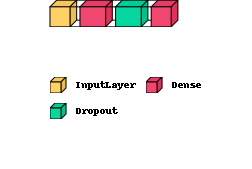

In [ ]:
#you have to install this package in order to visualize the model.
import visualkeras
visualkeras.layered_view(model, padding = 50, legend = True)

In [ ]:
yhat_probabilities = model.predict(X_test, batch_size=64)

6/6 [==============================] - 0s 801us/step


In [ ]:
y_hat = np.argmax(yhat_probabilities, axis = 1)
print(y_hat)

[0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0
 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1
 1 0 0 1]


In [ ]:
print(classification_report(y_test, y_hat,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.57      0.83      0.67       187
           1       0.68      0.36      0.47       187

    accuracy                           0.60       374
   macro avg       0.62      0.60      0.57       374
weighted avg       0.62      0.60      0.57       374



In [ ]:
df_outer = df_outer.reset_index(drop=True)
df_output =  pd.DataFrame(df_output).reset_index(drop=True)
df_outer = pd.concat([df_outer, pd.DataFrame(df_output)], axis =1)

### Evluate best models in each subject (best XG boosting classifier, base random forest model, tuned random forest model).

In [ ]:
def estimated_accuracy(clf,subject):
    m = df_outer[df_outer['ID']==subject]
    return cross_val_score(clf, m.iloc[:,0:-1], m.iloc[:,-1] , cv= 7).mean()

In [ ]:
[('subject '+str(subj), estimated_accuracy(tuned_xgboosting_model,subj)) for subj in range(1,31)]

[('subject 1', 0.9523809523809523),
 ('subject 2', 0.8551587301587301),
 ('subject 3', 0.9345238095238094),
 ('subject 4', 0.7857142857142857),
 ('subject 5', 0.9047619047619049),
 ('subject 6', 0.753968253968254),
 ('subject 7', 1.0),
 ('subject 8', 0.9206349206349207),
 ('subject 9', 0.7777777777777778),
 ('subject 10', 0.9186507936507936),
 ('subject 11', 0.9285714285714286),
 ('subject 12', 0.5694444444444444),
 ('subject 13', 0.9186507936507936),
 ('subject 14', 0.8134920634920635),
 ('subject 15', 0.7579365079365079),
 ('subject 16', 0.8988095238095237),
 ('subject 17', 0.871031746031746),
 ('subject 18', 0.7658730158730158),
 ('subject 19', 0.907936507936508),
 ('subject 20', 0.49603174603174605),
 ('subject 21', 0.6547619047619048),
 ('subject 22', 0.5694444444444444),
 ('subject 23', 0.8392857142857143),
 ('subject 24', 0.9007936507936508),
 ('subject 25', 0.7619047619047619),
 ('subject 26', 0.5734126984126985),
 ('subject 27', 0.9484126984126985),
 ('subject 28', 1.0),
 ('su

In [ ]:
[('subject '+str(subj), estimated_accuracy(tuned_rf_model,subj)) for subj in range(1,31)]

[('subject 1', 0.9503968253968254),
 ('subject 2', 0.8353174603174603),
 ('subject 3', 0.9503968253968254),
 ('subject 4', 0.7857142857142857),
 ('subject 5', 0.9206349206349207),
 ('subject 6', 0.7341269841269842),
 ('subject 7', 1.0),
 ('subject 8', 0.871031746031746),
 ('subject 9', 0.7876984126984128),
 ('subject 10', 0.886904761904762),
 ('subject 11', 0.9206349206349207),
 ('subject 12', 0.6547619047619048),
 ('subject 13', 0.9365079365079365),
 ('subject 14', 0.9007936507936508),
 ('subject 15', 0.7559523809523808),
 ('subject 16', 0.8690476190476192),
 ('subject 17', 0.8214285714285714),
 ('subject 18', 0.8015873015873015),
 ('subject 19', 1.0),
 ('subject 20', 0.5793650793650793),
 ('subject 21', 0.638888888888889),
 ('subject 22', 0.5972222222222222),
 ('subject 23', 0.8253968253968254),
 ('subject 24', 0.884920634920635),
 ('subject 25', 0.7281746031746031),
 ('subject 26', 0.46230158730158727),
 ('subject 27', 1.0),
 ('subject 28', 0.8412698412698413),
 ('subject 29', 0.918

In [ ]:
[('subject '+str(subj), estimated_accuracy(RandomForestClassifier(),subj)) for subj in range(1,31)]

[('subject 1', 0.9345238095238094),
 ('subject 2', 0.8373015873015872),
 ('subject 3', 0.9662698412698413),
 ('subject 4', 0.8015873015873016),
 ('subject 5', 0.9365079365079365),
 ('subject 6', 0.6865079365079365),
 ('subject 7', 1.0),
 ('subject 8', 0.886904761904762),
 ('subject 9', 0.8214285714285714),
 ('subject 10', 0.886904761904762),
 ('subject 11', 1.0),
 ('subject 12', 0.6230158730158729),
 ('subject 13', 0.9365079365079365),
 ('subject 14', 0.8829365079365079),
 ('subject 15', 0.7698412698412699),
 ('subject 16', 0.9186507936507936),
 ('subject 17', 0.8392857142857143),
 ('subject 18', 0.8015873015873015),
 ('subject 19', 0.9857142857142858),
 ('subject 20', 0.5952380952380952),
 ('subject 21', 0.6527777777777778),
 ('subject 22', 0.5833333333333333),
 ('subject 23', 0.8253968253968254),
 ('subject 24', 0.9007936507936508),
 ('subject 25', 0.7083333333333333),
 ('subject 26', 0.4642857142857143),
 ('subject 27', 0.9662698412698413),
 ('subject 28', 0.9107142857142857),
 ('su